<a href="https://colab.research.google.com/github/opinner/Articles/blob/main/Articles/Antarctic_Peninsula_3D_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h3>YES ! 🎉🎉🎉 This is a Colab version of the...</h3>
<h1>Antarctic 3D Maps using the IBCSO version 2 and PyGMT</h1>
</center>

**Very Important Note**: The Google Colaboratory, or just *colab*,  is a hosted Jupyter notebook service using a *free of charge* environment to computing resources including GPUs. The Python version changes all the time, as PyGMT does too. So, we have to install everything from scratch, but to do that you need exactly the time to make a good coffee. So click on the install block below, make yourself a nice cup of coffee, and when you're done it's ready for you to program.  

In this tutorial, let's use PyGMT with the brand new [International Bathymetric Chart of the Southern Ocean](https://ibcso.org/) Version 2 (IBCSO v2) from [Dorschel, B et al. (2022)](https://doi.pangaea.de/10.1594/PANGAEA.937574?format=html#download), to show you some of the most beautiful Antarctic gateways. 😉

You can change or adapt the scripts for your own use, always remembering to reference the IBCSO as the data source. If you're not already using PyGMT, just get started now (!). This is an excellent way to create your own beautiful maps.

However, if you're in a hurry, just send me a private message and I can try to adapt some of the examples for you (depending on the free time I have).

Let's start ?!

## Start here, and go to make a coffee during installation...

You just need to run this block below and during the next 2-3 minutes it will install the full GMT in your COLAB Virtual Machine. Just remember that when you log out, the VM disappears. So if you want to make changes and save them, I advise you to copy this notebook to your google drive.

**Note**: your session will crash, but it's normal (!). Just keep going....


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
%%capture
!mamba install pygmt #<- note qwe use mamba but you can do it with conda

In [3]:
# and if you don't believe in it
!gmt --version
!python --version

6.5.0
Python 3.11.11


## First of all, the data

The International Bathymetric Chart of the Southern Ocean Version 2 (IBCSO v2) is a digital bathymetric model (DBM) with a resolution of 500 m × 500 m in a polar stereographic projection (EPSG: 9354). In fact, you don't need to worry too much about it as 'PyGMT' can easily recognize the geographic grid. The first step is to download the data from PANGAEA, in particular the two grids [IBCSO_v2_ice-surface_WGS84.nc](https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_WGS84.nc) and [IBCSO_v2_bed_WGS84.nc](https://download.pangaea.de/dataset/937574/files/IBCSO_v2_bed_WGS84.nc).

The difference between the two is that the **ice-surface** contains the topography in meters including the glaciers and the **bed**, the subglacial bed reck elevation. In case you are looking for the map of the entire Southern Ocean, the [PDF distributed](https://download.pangaea.de/dataset/937574/files/IBSCO_v2_digital_chart.pdf) by the IBCSO is fantastic.

Please, download both files to the same location where you downloaded this jupyter notebook.

In [4]:
import os.path

In [5]:
# for the colab version, we use the 'wget' to the these data
if not os.path.isfile("/content/IBCSO_v2_ice-surface_WGS84.nc"):
  !wget https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_WGS84.nc
  #!wget https://download.pangaea.de/dataset/937574/files/IBCSO_v2_bed_WGS84.nc
else:
  print("IBSCO ice-surface is already downloaded")

IBSCO ice-surface is already downloaded


The next block is just a few routines to facilitate the work. Note that for some maps, we will create a custom color map with the [GMT color pallete](https://docs.generic-mapping-tools.org/latest/cookbook/cpts.html#built-in-color-palette-tables-cpt) tables 'abyss', for depths and 'gray' for elevation.

In [6]:
# a small function to help with depth limits
import math
def truncate_down(n):
    return(math.floor(n/100)*100)

def truncate_up(n):
    return(math.ceil(n/100)*100)

# create a custom colormap for some maps
def create_custom_cpt(min_depth,max_depth):

    # set limits for depth
    min_d = truncate_down(min_depth)
    max_d = truncate_down(max_depth)

    # create the colormap
    bathy_cpt = pygmt.makecpt(cmap='abyss',output='bathy.cpt',series=f'{min_d}/0/50',continuous=True)
    topo_cpt = pygmt.makecpt(cmap='gray',output='topo.cpt',series=f'0/{max_d+1000}/50', reverse=True, truncate=f"NaN/0.9")

    with open('bathy.cpt') as f:
        contents_bathy = f.readlines()
    with open('topo.cpt') as f:
        contents_topo = f.readlines()

    # merge colormap
    with open('combo.cpt', 'w') as f:
        f.writelines(contents_bathy[0:-3])
        f.writelines(contents_topo)

    f.close()
    return

## Second, let's get all the data

Let's use 'xarray' to open the netcdf files. Note in the structure that both data contains a regular grid of 3757 points in latitude and 33812 points in longitude, and that the variable 'z' corresponds to the elevation in meters referring to the current Mean Sea Level.

In [7]:
import xarray as xr

try:
  dset_ice = xr.open_dataset('IBCSO_v2_ice-surface_WGS84.nc',decode_coords='all')
  #dset_bed = xr.open_dataset('IBCSO_v2_bed_WGS84(1).nc',decode_coords='all')
except ValueError as e:
  print("nc file is probably not yet fully up/downloaded.\nWait for the uploading process in the lower left corner to finish, then try again")

# as an example
dset_ice

/usr/local/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


<xarray.Dataset> Size: 508MB
Dimensions:  (lat: 3757, lon: 33812)
Coordinates:
    crs      |S1 1B ...
  * lat      (lat) float64 30kB -90.0 -89.99 -89.97 ... -50.03 -50.02 -50.01
  * lon      (lon) float64 270kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    z        (lat, lon) float32 508MB ...
Attributes:
    Conventions:      CF-1.5
    title:            International Bathymetric Chart of the Southern Ocean (...
    institution:      Alfred Wegener Institute Helmholtz Centre for Polar and...
    contact:          Dr. Boris Dorschel, IBCSO@awi.de,southern-ocean@seabed2...
    comment:          The International Bathymetric Chart of the Southern Oce...
    doi:              https://doi.pangaea.de/10.1594/PANGAEA.937574
    webpage:          www.ibcso.org
    IBCSO_version:    2.0
    doi_publication:  https://doi.org/10.1038/s41597-022-01366-7

As the focus of this tutorial is on creating maps on the Antarctic Peninsula, let's cut out an area of interest. Note the small difference between 'bed' and 'ice'. The surface of the antarctic icesheets will appear in green (which corresponds to the color scale of the 'geo' palette used).

In [8]:
import pygmt

peninsula = [-68,-40,-80,-60]

#AP_bed = pygmt.grdcut(grid=dset_bed.z,region=peninsula,verbose='q')
AP_ice = pygmt.grdcut(grid=dset_ice.z,region=peninsula,verbose='q')

# resample for a resolution of 0.1 km
AP_ice_low=pygmt.grdsample(grid=AP_ice,spacing='0.1+k',verbose='q')

In [9]:
# # Note the max and min elevation in the grid
# print(f'IBCSO has a minimum depth of {AP_bed.min().values:.1f}'
#       f' and maximum of {AP_bed.max().values:.1f} meters relative to sea level.')
# min_depth = AP_bed.min().values
# max_depth = AP_bed.max().values

# min_d = truncate_down(min_depth)
# max_d = truncate_up(max_depth)
# create_custom_cpt(min_d,max_d)

# Note the max and min elevation in the grid
print(f'IBCSO has a minimum depth of {AP_ice.min().values:.1f}'
      f' and maximum of {AP_ice.max().values:.1f} meters relative to sea level.')
min_depth = AP_ice.min().values
max_depth = AP_ice.max().values

min_d = truncate_down(min_depth)
max_d = truncate_up(max_depth)
create_custom_cpt(min_d,max_d)

IBCSO has a minimum depth of -6326.0 and maximum of 2895.0 meters relative to sea level.


In [10]:
AP_ice_low

<xarray.DataArray 'z' (lat: 201, lon: 281)> Size: 226kB
array([[  104.      ,   104.      ,   104.84096 , ...,    86.      ,
           86.92779 ,    88.      ],
       [  104.952   ,   106.04524 ,   106.      , ...,    85.9192  ,
           83.946846,    83.952   ],
       [  105.064   ,   105.001564,   103.99745 , ...,    83.016   ,
           83.90726 ,    85.016   ],
       ...,
       [-3471.712   , -3555.804   , -3355.717   , ..., -1224.1393  ,
        -1435.5667  , -1479.768   ],
       [-3523.232   , -3495.4348  , -3498.6665  , ..., -1455.3386  ,
        -1513.3126  , -1598.24    ],
       [-3540.      , -3586.8726  , -3504.2866  , ..., -1506.6602  ,
        -1588.0499  , -1520.      ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 2kB -80.01 -79.91 -79.81 ... -60.19 -60.09 -59.99
  * lon      (lon) float64 2kB -68.01 -67.91 -67.81 -67.71 ... -40.2 -40.1 -40.0
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-6112.40869141  2450.13452148]
    long_name:     z

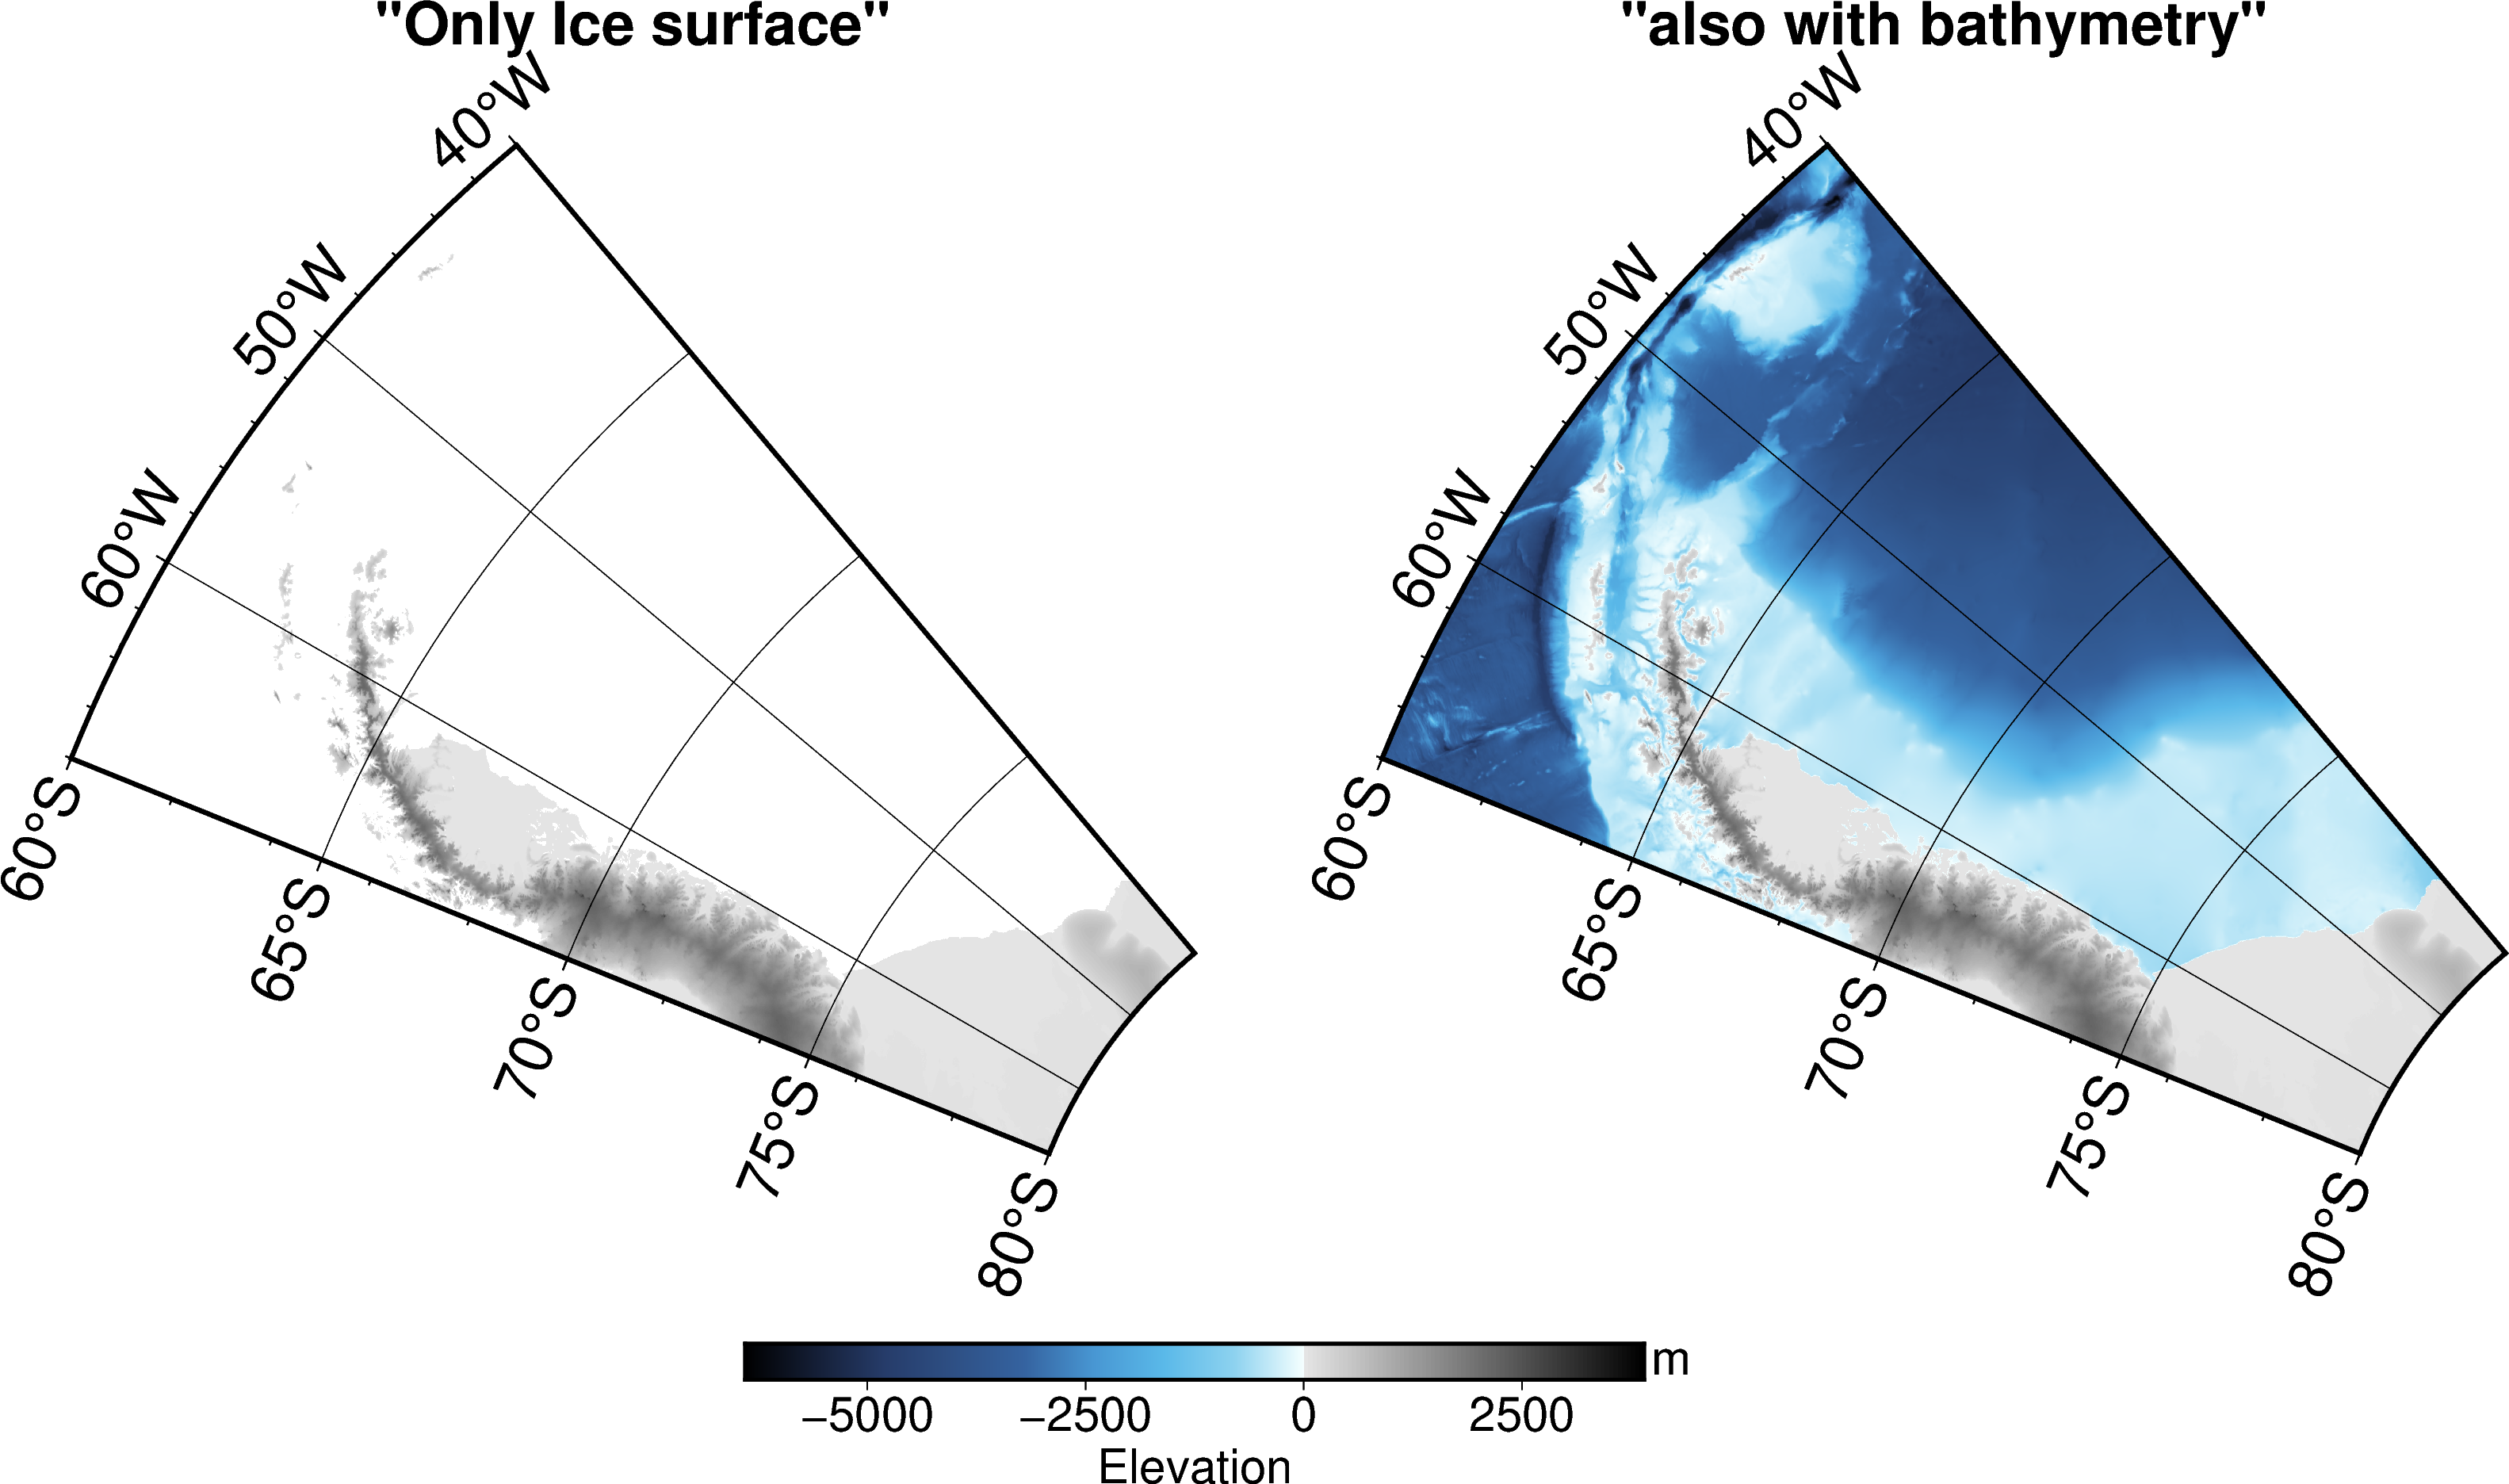

In [11]:
# let's try a comparative map of bed and ice
import pygmt
import numpy as np

fig = pygmt.Figure()
# define figure configuration
pygmt.config(FORMAT_GEO_MAP="dddF", MAP_FRAME_TYPE="plain",FONT='18p')

# --------------- plotting the IBCSO bed rock -----------
fig.grdimage(grid=AP_ice.where(AP_ice > 0, other=np.nan),nan_transparent=True,region=peninsula,projection="S0/-90/12c",frame=['xa10g10f','ya5g5f','+t"Only Ice surface"'],cmap='combo.cpt')

fig.shift_origin(xshift="6c",yshift="-1c")
fig.colorbar(frame=["a2500", "x+lElevation", "y+lm"])

# --------------- plotting the IBCSO ice surface -----------
fig.shift_origin(xshift="8c",yshift="1c")
fig.grdimage(grid=AP_ice,region=peninsula,projection="S0/-90/12c",frame=['xa10g10f','ya5g5f','+t"also with bathymetry"'],cmap='combo.cpt')

fig.show()

## A 3D map of the Antarctic Peninsula (South Shetland Islands point of view)

The [South Shetland Islands](https://en.wikipedia.org/wiki/South_Shetland_Islands) are a group of Antarctic islands located north of the Antarctic Peninsula, about 850 km southwest of [Cape Horn](https://en.wikipedia.org/wiki/Cape_Horn) (aprox. 463 nm across [Drake Passage](https://en.wikipedia.org/wiki/Drake_Passage)). When crossing this main gateway, any ship will be transiting in deep water (~3000 to 4000 meters deep) and from a geological point of view, the South Shetlands is basically a "huge cliff" that marks the edge of the Antarctic continent, as can be seen seen on this map.

Some notes for the coder:
- as geographically proximity to the pole generates a distortion for a 3D map, here the code chooses to represent the surface in projection [Lambert Conic Conformal](https://www.pygmt.org/dev/projections/conic/conic_lambert.html). Be careful if you want to change this.
- note that the base of the figure is actually geographic north, to demonstrate the huge difference in height.
- the perception of geological features changes with a different shading angle. If you want to change this, I suggest small changes.
- it is possible to note the enormous topographical variability of the Scotia arc, which is the northern edge of the Shetlands.
- The color palette here is 'geo' and that's why the colors look so unreal. Also note that 'grdview' is used with the surface type 'surftype'="s" or "surface".

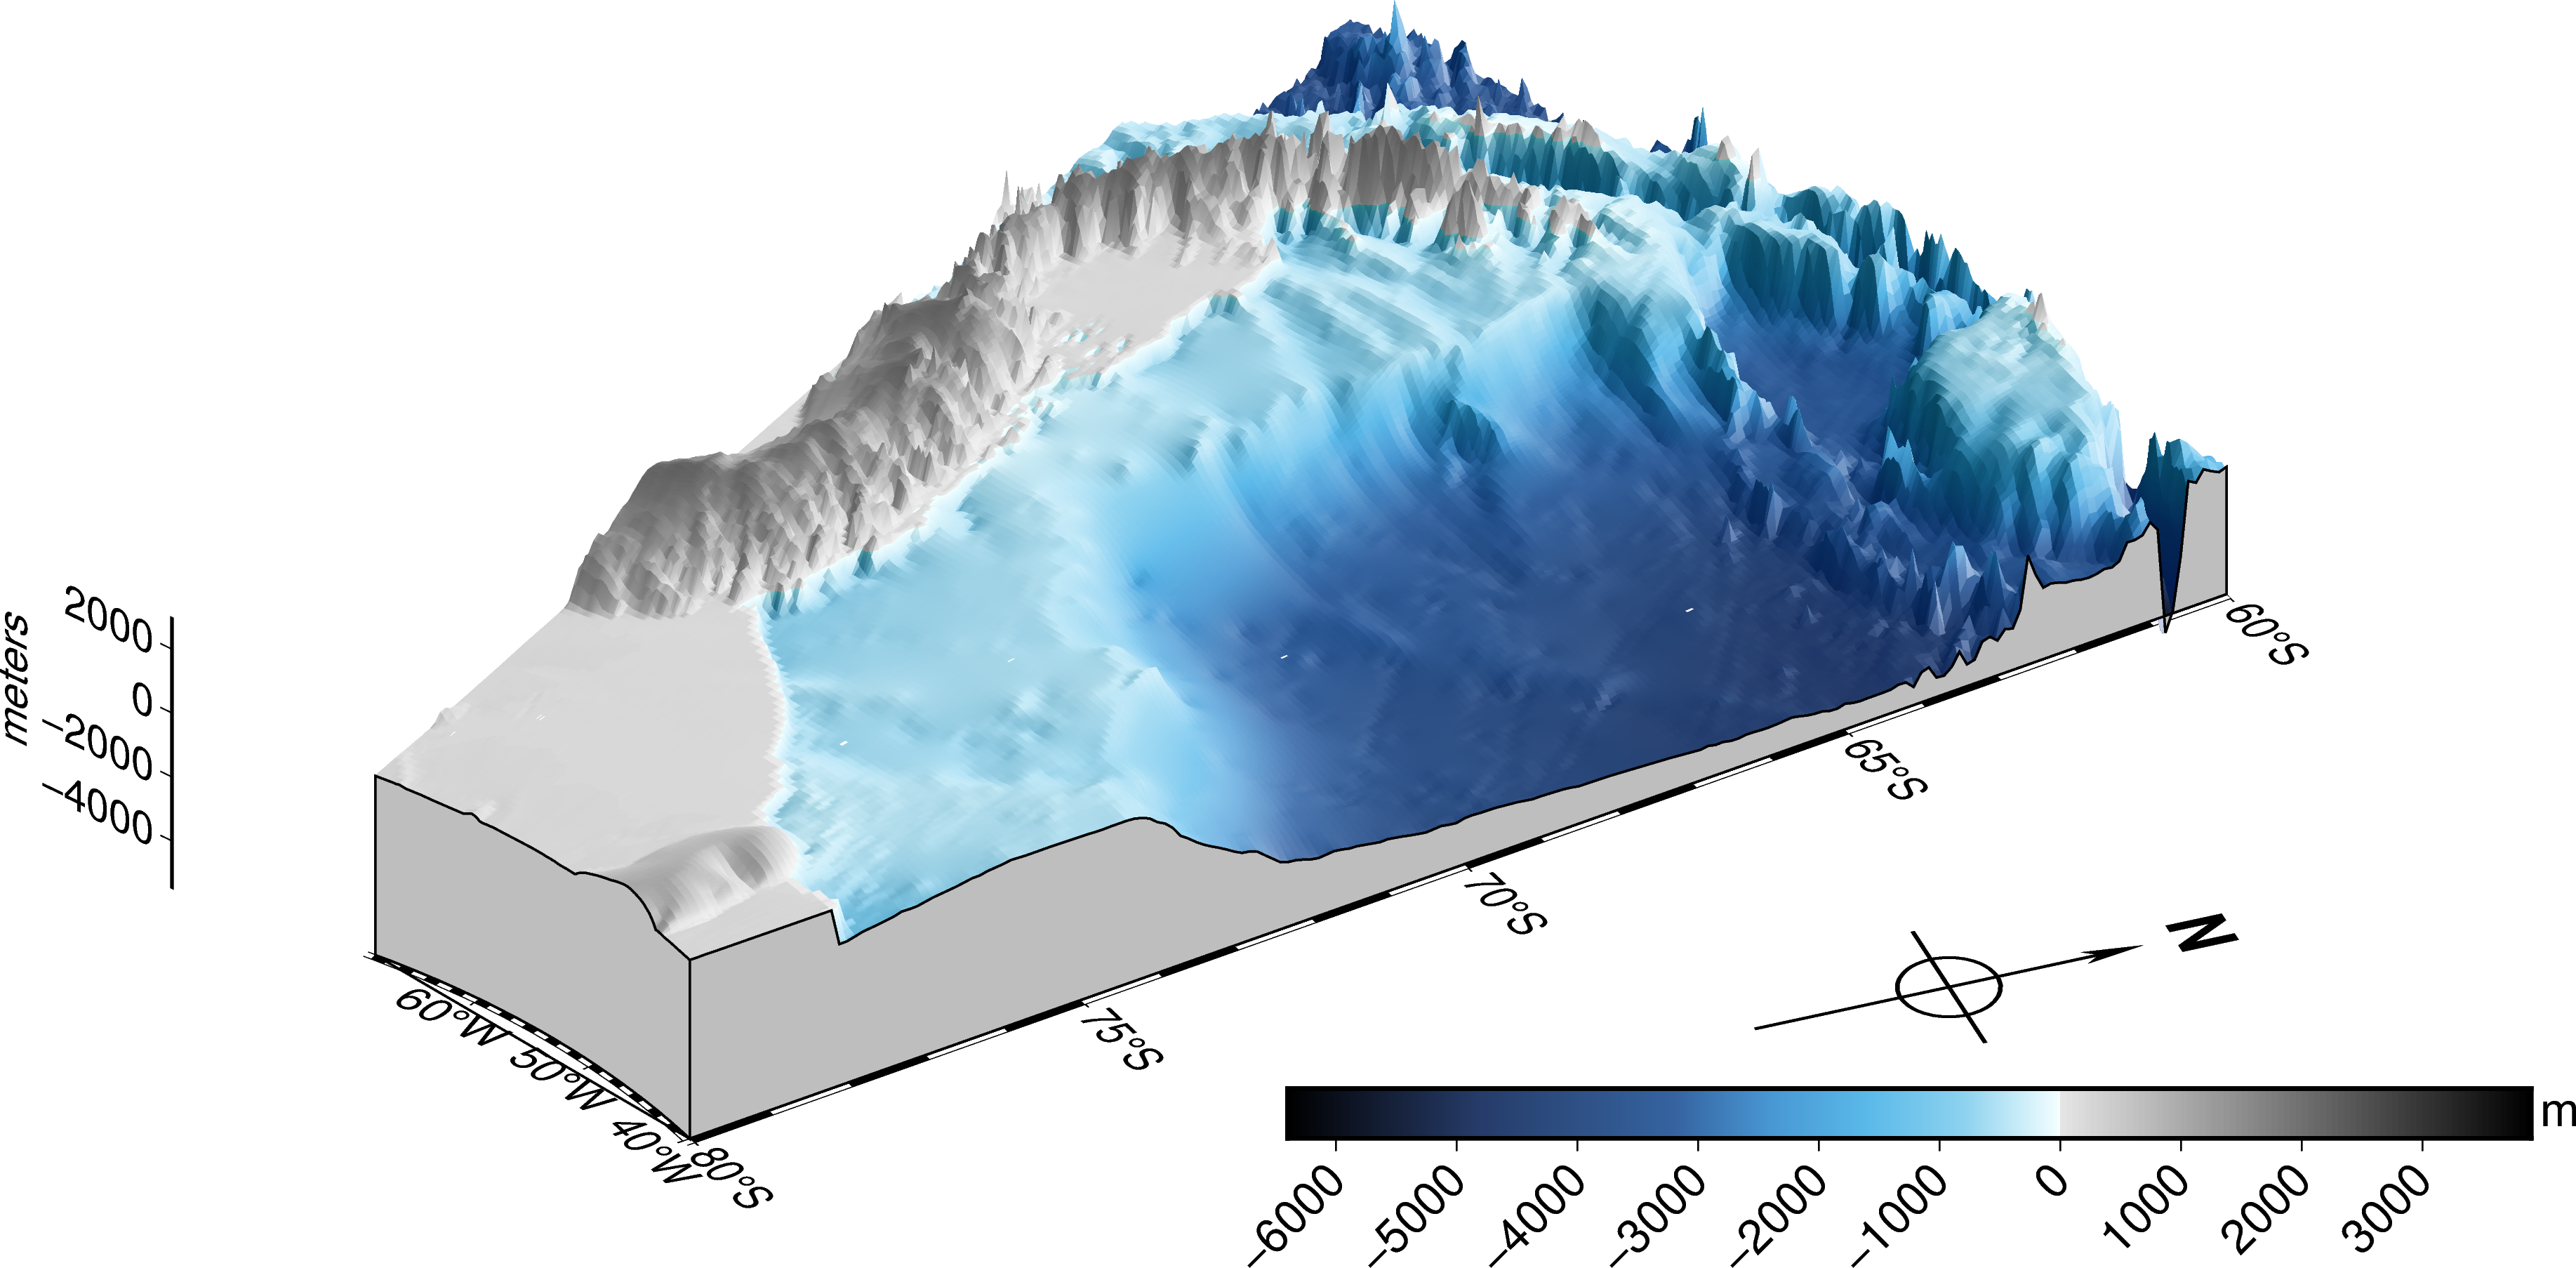

In [12]:
# let's make the figure
fig = pygmt.Figure()

pygmt.config(FORMAT_GEO_MAP="dddF", MAP_FRAME_TYPE="fancy")

# note I can add projection, after cmap and after, frame (and control frame)
#topo_cpt = pygmt.makecpt(cmap='combo.cpt',series=f'-5500/3000/50',continuous=True)
frame =  ["xa10f1+f","ya5f1+f", "z2000+lmeters", "ESZ"]

with pygmt.config(FONT='18p'):
    fig.shift_origin(xshift='15c')
    fig.grdview(grid=AP_ice_low,
                region=peninsula+[-5500,3000],
                frame=frame,
                perspective=[140,35], # set the perspective here
                projection='L-60/-65/-72/-60/15c', # set the projection
                zsize='4c',
                surftype='s',
                cmap='combo.cpt',
                plane="-5500+ggrey", # set the plane of the map
                shading='+a20+nt1') # caution with the shading
    fig.basemap(
        perspective=True,
        rose="JCL+w5c+l+o-19c/1c" # map directional rose at the center (MAP) left with a little shift
    )

with pygmt.config(FONT='16p'):
    fig.shift_origin(xshift='12c')
    #fig.colorbar(frame=["a1000", "x+lElevation", "y+lm"], position='+w15c+o6c/-11c+v', shading='+a20+nt1')
    fig.colorbar(frame=["a1000+a45", "x", "y+lm"], position='+w15c+o-1c/0c+h')

fig.show()

# https://www.pygmt.org/latest/api/generated/pygmt.Figure.psconvert.html#pygmt.Figure.psconvert
#fig.psconvert(fmt="f",prefix="3D")
# convert to jpg
fig.psconvert(fmt="j",prefix="3D")
#fig.savefig('3D.eps', dpi=800)

In [13]:
#from google.colab import files
#files.download('3D.jpg')

# Add satellite image of the peninsula

In [14]:
! mamba install rioxarray
import rioxarray


Looking for: ['rioxarray']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [15]:
if not os.path.isfile("/content/Antarctica_Satellite_image.tif"):
  ! wget https://lima.usgs.gov/tiff_90pct.zip
  ! unzip tiff_90pct.zip
  ! mv tiff_90pct/00000-20080319-092059124.tif /content/Antarctica_Satellite_image.tif
  ! rm /content/tiff_90pct.zip
else:
  print("LIMA satellite image is already downloaded")

LIMA satellite image is already downloaded


In [16]:
# lima data is downloaded from link: https://lima.usgs.gov/tiff_90pct.zip
circum_antarctic_satellite = rioxarray.open_rasterio(
    filename="/content/Antarctica_Satellite_image.tif",
    parse_coordinates=True,
    dtype="uint8",
    count=3,
    nodata=0
)
circum_antarctic_satellite

<xarray.DataArray (band: 3, y: 19404, x: 22841)> Size: 1GB
[1329620292 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 183kB -2.668e+06 -2.668e+06 ... 2.813e+06 2.814e+06
  * y            (y) float64 155kB 2.362e+06 2.362e+06 ... -2.294e+06 -2.295e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [17]:
for entry in circum_antarctic_satellite.spatial_ref.attrs.items():
  print(f"{entry[0]}: {entry[1]}")

crs_wkt: PROJCS["Polar Stereographic",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-71],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",NORTH],AXIS["Northing",NORTH]]
semi_major_axis: 6378137.0
semi_minor_axis: 6356752.314245179
inverse_flattening: 298.257223563
reference_ellipsoid_name: WGS 84
longitude_of_prime_meridian: 0.0
prime_meridian_name: Greenwich
geographic_crs_name: WGS 84
horizontal_datum_name: World Geodetic System 1984
projected_crs_name: Polar Stereographic
grid_mapping_name: polar_stereographic
standard_parallel: -71.0
straight_vertical_longitude_from_pole: 0.0
false_easting: 0.0
false_northing: 0.0
spatial_ref: PROJCS["Polar Stereographic",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS

In [18]:
# @title Cut satellite image down to the Antarctic peninsula
import pyproj
# select Polar Stereographic, with standard_parallel: -71.0 as described in the attributes above
ps_proj = pyproj.Proj(proj="stere", lat_ts=-71, lat_0=-90, lon_0=0, ellps="WGS84")
peninsula = [-68,-40,-80,-60]
# Four corners of the bounding box
lons = [peninsula[0], peninsula[1], peninsula[0], peninsula[1]] # lon_min, lon_max, lon_max, lon_min
lats = [peninsula[2], peninsula[2], peninsula[3], peninsula[3]] # lat_min, lat_min, lat_max, lat_max

# Convert to stereographic x, y
x, y = ps_proj(lons, lats)

# Get min/max in projected space
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

In [19]:
satellite = circum_antarctic_satellite.sel(
    x=slice(x_min, x_max),
    y=slice(y_max, y_min)  # order is dependent on the direction of the coordinate axis, switch if necessary
) #.astype("uint8")
satellite

<xarray.DataArray (band: 3, y: 8143, x: 8200)> Size: 200MB
[200317800 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 66kB -2.668e+06 -2.668e+06 ... -7.003e+05
  * y            (y) float64 65kB 2.362e+06 2.362e+06 ... 4.084e+05 4.081e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
import matplotlib.pyplot as plt

In [21]:
# Test if the bounding box was correctly set
if False:
  !pip install cartopy
  import cartopy.crs as ccrs

  fig = plt.figure(figsize=(12, 4))
  # Select the map projection
  ax = fig.add_subplot(1, 2, 1,
                      projection=ccrs.SouthPolarStereo()
                      )
  image = satellite.transpose("y","x","band") # imshow expects the shape (M,N,3)
  ax.imshow(image, transform=ccrs.SouthPolarStereo(), extent=peninsula, origin='upper')
  gl = ax.gridlines(draw_labels=True)
  gl.xlabels_top = False
  gl.ylabels_left = True
  ax.set_title("with cartopy")
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.imshow(image)
  ax2.set_title("without cartopy");
else:
  print("Cartopy is not installed")

Cartopy is not installed


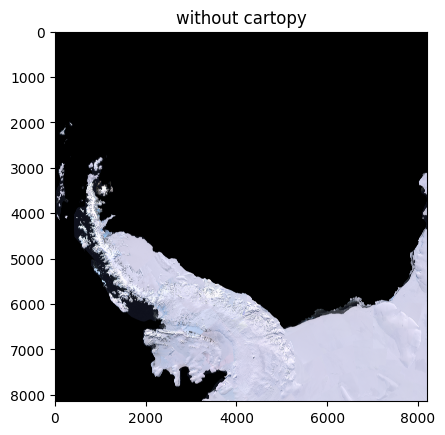

In [22]:
# Test if the bounding box was correctly set
image = satellite.transpose("y","x","band") # imshow expects the shape (M,N,3)
plt.imshow(image)
plt.gca().set_title("without cartopy");

In [23]:
# def get_land_mask(rgb_array):

#   # Identify completely black pixels: all bands == 0
#   black_mask = (rgb_array == 0).all(dim="band")

#   # Expand mask to all bands
#   # Add dummy band dimension so it can broadcast with original data
#   black_mask_expanded = black_mask.expand_dims(dim={"band": rgb_array.sizes["band"]})
#   return black_mask

# def get_masked_land(rgb_array):

#   # Identify completely black pixels: all bands == 0
#   black_mask = (rgb_array == 0).all(dim="band")

#   # Expand mask to all bands
#   # Add dummy band dimension so it can broadcast with original data
#   black_mask_expanded = black_mask.expand_dims(dim={"band": rgb_array.sizes["band"]})
#   #return black_mask
#   masked = rgb_array.astype("uint8").where(~black_mask_expanded) #
#   return masked

In [24]:
# # Assume `satellite` is already loaded from a NetCDF or GeoTIFF, e.g.:
# # satellite = xr.open_dataarray("image.nc")
# small_satellite = land_mask.coarsen(x=50, y=50, boundary="trim").max()

# # Define region
# region = [
#     float(small_satellite.x.min()),
#     float(small_satellite.x.max()),
#     float(small_satellite.y.min()),
#     float(small_satellite.y.max())
# ]
# print(region)
# small_satellite

In [25]:
# reproject from southpolarstereo to WGS84
# Without this, I did not get pygmt to plot the satellite image correctly
satellite_lonlat = satellite.rio.reproject("WGS84")
satellite_lonlat

<xarray.DataArray (band: 3, y: 10498, x: 27732)> Size: 873MB
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)
Coordinates:
  * x            (x) float64 222kB -81.3 -81.3 -81.3 ... -16.52 -16.51 -16.51
  * y            (y) float64 84kB -58.02 -58.03 -58.03 ... -82.55 -82.55 -82.55
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     255

In [26]:
print(AP_ice_low.shape, AP_ice_low.rio.bounds())
print(satellite_lonlat.shape, satellite_lonlat.rio.bounds())

(201, 281) (-68.058970347192, -80.05876669134265, -39.9465234007897, -59.94222029483416)
(3, 10498, 27732) (-81.30605296137499, -82.55215257461344, -16.510280666295735, -58.0235928762959)


In [27]:
reshaped_satellite_lonlat = satellite_lonlat.sel(
    x=slice(peninsula[0], peninsula[1]),
    y=slice(peninsula[3], peninsula[2])  # order is dependent on the direction of the coordinate axis, switch if necessary
)
reshaped_satellite_lonlat

<xarray.DataArray (band: 3, y: 8560, x: 11984)> Size: 308MB
array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [207, 207, 207, ..., 199, 199, 199],
        [206, 206, 206, ..., 203, 203, 203],
        [208, 208, 208, ..., 207, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [207, 207, 207, ..., 201, 201, 201],
        [206, 206, 206, ..., 205, 205, 205],
        [206, 206, 206, ..., 209, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [231, 231, 231, ..., 224, 226, 226],
        [230, 230, 230, ..., 228, 228, 228],
        [230, 230, 230, ..., 230, 255, 255]]], dtype=uint8)
Coordinates:
  * x            (x) float64 96kB -68.0 -68.0 -67.99 ... -40.0 -40.0 -40.0
  * y            (y) float64 68kB -60.0 -60.0 -60.01 ... -79.99 -80.0 -80.0
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     255

In [28]:
print(AP_ice_low.shape, AP_ice_low.rio.bounds())
print(reshaped_satellite_lonlat.shape, reshaped_satellite_lonlat.rio.bounds())

(201, 281) (-68.058970347192, -80.05876669134265, -39.9465234007897, -59.94222029483416)
(3, 8560, 11984) (-67.99969484726579, -80.00069637433121, -39.999098598014754, -60.00027048200905)


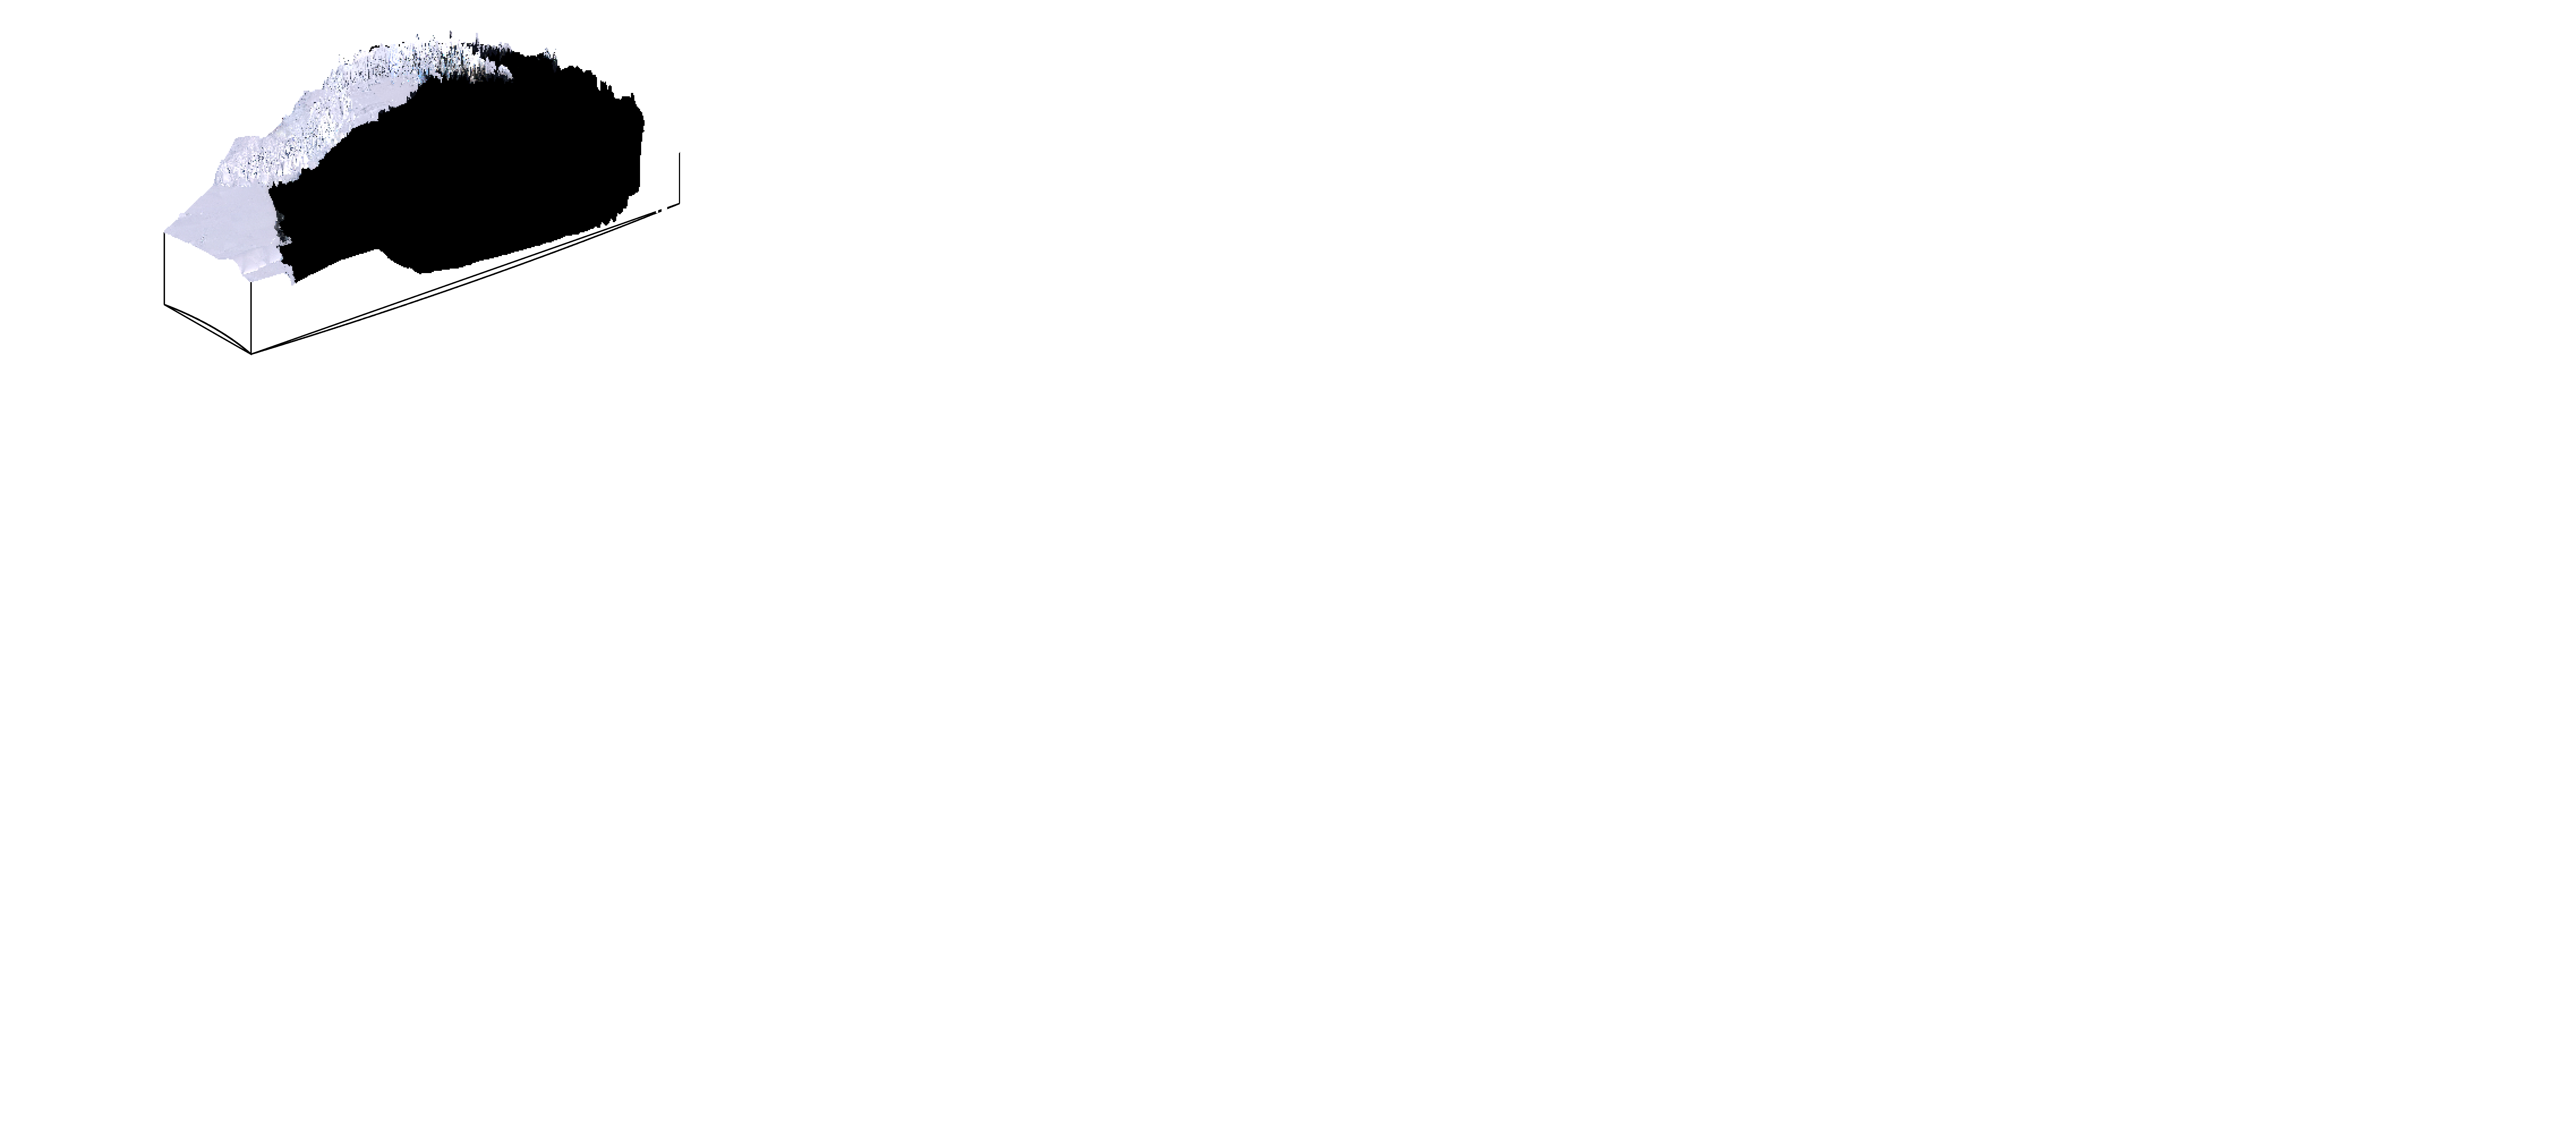

In [48]:
# perspective = [140,35]
# #projection = 'g-60/-65/-72/-60/15c'
#projection="S-50/90/15c" #Slon0/lat0[/horizon]/width
#projection='H-20/15c'
#projection="G-50/-70/1500/10c"
#projection='T-60/-70/15c' #Transverse Mercator projection
#projection='B-60/-65/-72/-60/15c'
#projection="Poly/-60/-70/15c"
projection="G-60/-70/16c+a0+t0+v60/60+w0+z3000", #Glon0/lat0/width[+aazimuth][+ttilt][+vvwidth/vheight][+wtwist][+zaltitude]
# projection='A-60/-65/15c'
perspective = [140,35]


fig = pygmt.Figure()
# frame=['+t"satellite image with grdimage"']
# fig.grdimage(
#     grid=reshaped_satellite_lonlat,
#     frame=frame,
#     region=peninsula,
#     perspective=perspective, # set the perspective here
#     projection=projection, # set the projection
# )

# fig.shift_origin(xshift='17c')
# frame=['+t"data array with grdview"']
# fig.grdview(
#     grid=AP_ice_low,
#     region=peninsula+[-5500,3000],
#     perspective=perspective, # set the perspective here
#     projection=projection, # set the projection
#     surftype="s",
#     zsize='3c',
#     cmap='gray',
#     plane="-5500", # set the plane of the map
#     shading='+a20+nt1' # caution with the shading
# )

#fig.shift_origin(xshift='17c')
fig.shift_origin(xshift="0.1c")
frame=['+t"satellite image draped over data with grdview"']
fig.grdview(
    grid=AP_ice_low,
    region=peninsula+[-5500,3000],
    perspective=perspective, # set the perspective here
    projection=projection, # set the projection
    drapegrid=reshaped_satellite_lonlat,  # LIMA image layer
    surftype="c100", #low resolution drape, same as image surface i but makes nodes with z = NaN transparent.
    zsize='3c',
    cmap='gray',
    plane="-5500", # set the plane of the map
    #shading='+a20+nt1' # caution with the shading
)



fig.show()

In [30]:
raise AssertionError

AssertionError: 

# TODO DEBUGGING
**Why does grdimage work, but grdview cuts off the data?**

In [ ]:
# let's make the figure
fig = pygmt.Figure()

pygmt.config(FORMAT_GEO_MAP="dddF", MAP_FRAME_TYPE="fancy")

# note I can add projection, after cmap and after, frame (and control frame)
#topo_cpt = pygmt.makecpt(cmap='combo.cpt',series=f'-5500/3000/50',continuous=True)
frame =  ["xa10f1+f","ya5f1+f", "z2000+lmeters", "ESZ"]

with pygmt.config(FONT='18p'):
    fig.shift_origin(xshift='15c')
    fig.grdview(grid=AP_ice_low, #.where(AP_ice_low < 0),
                region=peninsula+[-5500,3000],
                frame=frame,
                perspective=perspective, # set the perspective here
                projection=projection, # set the projection
                zsize='3c',
                surftype='s',
                cmap='abyss',
                plane="-5500+ggrey", # set the plane of the map
                shading='+a20+nt1', # caution with the shading
    )

fig.grdview(grid=AP_ice_low.where(AP_ice_low >= 0, np.nan),
            region=peninsula+[-5500,3000],
            perspective=perspective, # set the perspective here
            projection=projection, # set the projection
            drapegrid=reshaped_satellite_lonlat,  # LIMA image layer
            surftype="c2000", #highest resolution drape, same as image surface i but makes nodes with z = NaN transparent.
            zsize='3c',
            cmap='gray',
            plane="-5500", # set the plane of the map, but do not give it color
            shading=None # satellite image looks way better without shading
)

fig.basemap(
    perspective=True,
    rose="JCL+w5c+l+o-19c/1c" # map directional rose at the center (MAP) left with a little shift
)

with pygmt.config(FONT='16p'):
    fig.shift_origin(xshift='12c')
    #fig.colorbar(frame=["a1000", "x+lElevation", "y+lm"], position='+w15c+o6c/-11c+v', shading='+a20+nt1')
    fig.colorbar(cmap="abyss", frame=["a1000+a45", "x", "y+lm"], position='+w15c+o-1c/0c+h')

fig.show()

# https://www.pygmt.org/latest/api/generated/pygmt.Figure.psconvert.html#pygmt.Figure.psconvert
#fig.psconvert(fmt="f",prefix="3D")
# convert to jpg
fig.psconvert(fmt="j",prefix="fancy3D", dpi=400)

In [ ]:
# let's make the figure
fig = pygmt.Figure()

pygmt.config(FORMAT_GEO_MAP="dddF", MAP_FRAME_TYPE="fancy")

# conic lambert
perspective = [145,35]
projection = 'L-60/-65/-72/-60/15c'
projection="G-60/-70/16c+a0+t0+v60/60+w0+z3000", #Glon0/lat0/width[+aazimuth][+ttilt][+vvwidth/vheight][+wtwist][+zaltitude]

# note I can add projection, after cmap and after, frame (and control frame)
#topo_cpt = pygmt.makecpt(cmap='combo.cpt',series=f'-5500/3000/50',continuous=True)
frame =  ["xa10f1+f","ya5f1+f", "z2000+lmeters", "ESZ"]

with pygmt.config(FONT='18p'):
    # fig.shift_origin(xshift='15c')
    fig.grdview(
        grid=AP_ice_low, #.where(AP_ice_low < 0),
        region=peninsula+[-5500,3000],
        frame=frame,
        perspective=perspective, # set the perspective here
        projection=projection, # set the projection
        zsize='2c',
        surftype='s',
        cmap='abyss',
        plane="-5500+ggrey", # set the plane of the map
        shading='+a20+nt1', # caution with the shading
    )

fig.grdview(
    grid=AP_ice_low.where(AP_ice_low >= 0, np.nan), #only above sea level
    region=peninsula+[-5500,3000],
    perspective=perspective, # set the perspective here
    projection=projection, # set the projection
    drapegrid=reshaped_satellite_lonlat,  # LIMA image layer
    surftype="c2000", #highest resolution drape, same as image surface i but makes nodes with z = NaN transparent.
    zsize='2c',
    cmap='gray',
    plane="-5500", # set the plane of the map, but do not give it color
    shading=None # satellite image looks way better without shading
)

# fig.basemap(
#     perspective=True,
#     rose="JCL+w5c+l+o-19c/1c" # map directional rose at the center (MAP) left with a little shift
# )

# with pygmt.config(FONT='16p'):
#     fig.shift_origin(xshift='12c')
#     #fig.colorbar(frame=["a1000", "x+lElevation", "y+lm"], position='+w15c+o6c/-11c+v', shading='+a20+nt1')
#     fig.colorbar(cmap="abyss", frame=["a1000+a45", "x", "y+lm"], position='+w15c+o-1c/0c+h')

fig.show()

# https://www.pygmt.org/latest/api/generated/pygmt.Figure.psconvert.html#pygmt.Figure.psconvert
#fig.psconvert(fmt="f",prefix="3D")
# convert to jpg
fig.psconvert(fmt="j",prefix="fancy3D", dpi=400)

grdview (GMT_grdview): Could not reallocate memory [17179869182.49 Gb, 18446744072086837023 items of 1 bytes]


# Why?
**It almost works, but the satellite image is cut off**

## Deception Island

One of the main highlights for those who sail in the area of the peninsula is [Deception Island](https://en.wikipedia.org/wiki/Deception_Island), known for being an 'almost' quiet natural harbor, and also for its underlying active volcano (yes! active!). From the figure below, it is possible to see that the deep waters of the Bransfield Strait are the result not only of volcanic activity at the edge of the South Shetland Islands Block (SSIB) but also of the separation of the SSIB and the South Orkney microcontinent (SOM) (see details in [Riley et al, 2019](https://www.researchgate.net/publication/334468597_Geochronology_and_geochemistry_of_the_northern_Scotia_Sea_A_revised_interpretation_of_the_North_and_West_Scotia_ridge_junction)).


A few notes for the coder:
- Note that the projection here has been changed as the area is much smaller.
- Arrow indicates geographic north for reference.
- Eventually you can also point out that the volcano of deception has a steeper flank than the other, a result of the hotspot drift over the plate.

In [ ]:
deception = [-62.8,-58.5,-63.4,-62.5]

Deception_ice = pygmt.grdcut(grid=dset_ice.z,region=deception,verbose='q')

# Note the max and min elevation in the grid region

deception_min_depth = Deception_ice.min().values
deception_max_depth = Deception_ice.max().values

min_d = truncate_down(deception_min_depth)
max_d = truncate_up(deception_max_depth)

print(f'IBCSO-Deception area has a minimum depth of {deception_min_depth:.1f}'
      f' and maximum of {deception_max_depth:.1f} meters relative to sea level.')

# create a custom colormap for these min max depths
create_custom_cpt(min_d,max_d)

In [ ]:
fig = pygmt.Figure()

with pygmt.config(FORMAT_GEO_MAP="ddd.xxF", MAP_FRAME_TYPE="fancy",FONT='22p'):
    fig.grdview(grid=Deception_ice,
                region=deception+[min_d,max_d],
                frame=["xa1f0.5","ya0.5f0.25","z1000+lmeters","wSEnZ"],
                perspective=[150,35], # set the perspective here
                projection='M18c', # projection use is Mercartor
                zsize='5c',
                surftype='i',
                cmap='combo.cpt',
                plane=f"{min_d}+ggrey",
                shading='+a150+nt1')
    fig.basemap(
        perspective=True,
        rose="JCR+w5c+l+o2.5c/0c" # map directional rose at the center (MAP) right with a little shift
    )

with pygmt.config(FONT='16p'):
    fig.colorbar(cmap='combo.cpt',frame=["a1000", "x+lElevation", "y+lm"])

fig.show()


## Gerlache strait

The [Gerlache Strait](https://en.wikipedia.org/wiki/Gerlache_Strait) is a channel that separates the [Palmer Archipelago](https://en.wikipedia.org/wiki/Palmer_Archipelago) (the islands clearly identified on the right side in the map below) from the Antarctic Peninsula (on the map, top left). Note that the geographic north arrow points downwards as this is the best viewing angle for the deep channel in Gerlache. The embayments on the Peninsula are magical places, with fantastic views of peaks that rise up to 2600 m above sea level. Note that we are using 'ice-surface' data here.

Both the deep channel at Gerlache and the northern part of [Anvers Island](https://en.wikipedia.org/wiki/Anvers_Island) were excavated during the last deglaciation.

In [ ]:
gerlache = [-64,-61,-65.0,-63.5]
Gerlache_ice = pygmt.grdcut(grid=dset_ice.z,region=gerlache,verbose='q')

# Note the max and min elevation in the grid region

gerlache_min_depth = Gerlache_ice.min().values
gerlache_max_depth = Gerlache_ice.max().values

min_d = truncate_down(gerlache_min_depth)
max_d = truncate_up(gerlache_max_depth)

print(f'IBCSO-Gerlache area has a minimum depth of {gerlache_min_depth:.1f}'
      f' and maximum of {gerlache_max_depth:.1f} meters relative to sea level.')

# create a custom colormap for these min max depths
create_custom_cpt(min_d,max_d)


In [ ]:
fig = pygmt.Figure()

with pygmt.config(FORMAT_GEO_MAP="ddd.xxF", MAP_FRAME_TYPE="fancy",FONT='22p'):
    fig.grdview(grid=Gerlache_ice,
                region=gerlache+[min_d,max_d],
                frame=["xa1f0.5","ya0.5f0.25","z1000+lmeters","wsENZ"],
                perspective=[25,45], # check the perspective angle
                projection='M20c', # check the projection here
                zsize='4c',
                surftype='i',
                cmap='combo.cpt',
                plane=f"{min_d}+ggrey",
                shading='+a150+nt1')
    fig.basemap(
        perspective=True,
        rose="JTC+w5c+l+o0c/0.5c" # map directional rose at the top (MAP) center with a little shift
    )

with pygmt.config(FONT='20p'):
    fig.shift_origin(xshift='2c',yshift='-1.5c')
    fig.colorbar(cmap='combo.cpt',frame=["a1000", "x+lElevation", "y+lm"])

fig.show()


## Polar Circle

The [Polar Circle](https://en.wikipedia.org/wiki/Antarctic_Circle) is a geographic term for a latitudinal position where the Sun is above the horizon for 24 continuous hours at least once a year (and therefore visible at midnight) after the [Austral Solstice in December](https://en.wikipedia.org/wiki/December_solstice). The exact position of the Antarctic Circle is not fixed (but we can say that it is currently around 66°33′ S.) because its latitude depends on the [Earth's axial tilt](https://en.wikipedia.org/wiki/Astronomical_nutation), which fluctuates within a margin of more than 2° over a period of 41,000 years.

Regardless, it is also a magical mark for those who navigate the waters of the Southern Ocean. The code block below generates the map of the region and marks the current Antarctic Polar Circle in small red dots on the map.

Note to coders:
- With the region of interest configured, we take the maximum and minimum values of longitude and extract the elevations over the latitude of 66°33′ S with the 'grdtrack' function, to a 'pandas' dataframe.
- the points are then plotted on the map as a series of very small red circles using 'plot3d'
- again, pay attention to the geographic north that points to the left and down on the map, due to perspective.
- It is possible to observe that the continental shelf there is very shallow, the result of an intense process of sedimentation driven by glacial forces.

In [ ]:
polarcircle = [-67.8,-63.5,-67,-64.5]
Polarcircle_ice = pygmt.grdcut(grid=dset_ice.z,region=polarcircle,verbose='q')

# Note the max and min elevation in the grid region

polarcircle_min_depth = Polarcircle_ice.min().values
polarcircle_max_depth = Polarcircle_ice.max().values

min_d = truncate_down(polarcircle_min_depth)
max_d = truncate_up(polarcircle_max_depth)

print(f'IBCSO-Polar Circle area has a minimum depth of {polarcircle_min_depth:.1f}'
      f' and maximum of {polarcircle_max_depth:.1f} meters relative to sea level.')

# create a custom colormap for these min max depths
create_custom_cpt(min_d,max_d)


In [ ]:
Polarcircle_ice

In [ ]:
# create a track over the polar circle with min & max longitudes (50 dots)

import numpy as np
import pandas as pd

longitude = np.linspace(Polarcircle_ice.lon.min(),Polarcircle_ice.lon.max(),50)
latitude = [-66.5667] * len(longitude)
points = pd.DataFrame(data={'longitude':longitude,'latitude':latitude})

output_PC = pygmt.grdtrack(points=points, grid=Polarcircle_ice, newcolname="z_PC")

In [ ]:
fig = pygmt.Figure()

perspective = [-40,35]
projection = 'M20c'

with pygmt.config(FORMAT_GEO_MAP="ddd.xxF", MAP_FRAME_TYPE="fancy",FONT='22p'):
    fig.grdview(grid=Polarcircle_ice,
                region=polarcircle+[min_d,max_d],
                frame=["xa1f0.5","ya0.5f0.25","z1000+lmeters","WseNZ"],
                perspective=perspective, # note the perspective
                projection=projection, # and projection
                zsize='4c',
                surftype='i',
                cmap='combo.cpt',
                plane=f"{min_d}+ggrey",
                shading='+a150+nt1')
    fig.plot3d(x=output_PC['longitude'], # here we plot the polar circle dots
               y=output_PC['latitude'],
               z=output_PC['z_PC'],
               fill='red',
               style='c0.2c',
               perspective=perspective,
               projection=projection,
              )
    fig.basemap(
        perspective=True,
        rose="JTC+w5c+l+o0c/0.5c" # map directional rose at the top (MAP) center with a little shift
    )

with pygmt.config(FONT='20p'):
    fig.shift_origin(xshift='2c',yshift='-1.5c')
    fig.colorbar(cmap='combo.cpt',frame=["a1000", "x+lElevation", "y+lm"])

fig.show()


## Antarctic Sound

Last but not least, the [Antarctic Sound](https://en.wikipedia.org/wiki/Antarctic_Sound) is a gateway about 30 nautical miles (approx. 56 km) in length and no more than 7 to 12 nautical miles (13 to 22 km) wide and separating the extreme northeast of the Antarctic Peninsula, a passage to the [Wedell Sea](https://en.wikipedia.org/wiki/Weddell_Sea), home of the great icebergs. This passage is also essential for the flow of water between the east and west sides of the peninsula.

In addition to the western tip of [Joinville Island](https://en.wikipedia.org/wiki/Joinville_Island), there is also a group of islands called the [Danger Islands](https://en.wikipedia.org/ wiki/Danger_Islands), a tiny group with almost 1.5 million noisy individuals of [Adélie penguins](https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin). This is one of the most special places (among many!) in this passage between Bransfield and the Weddell Sea, where history and nature mix.

Note to coders:
- here the perspective is at 45°, and north points up and to the right. You can see in the upper part of the map the great canyons of the tip of the peninsula, a result of intense glaciation in the past, as well as on the left side, the channel that separates [James Ross Island](https://en.wikipedia.org/ wiki/James_Ross_Island) from the mainland.
- This is the map with the smallest variation in topography (from -1825.0 to a maximum of 1640.0 meters relative to sea level)

In [ ]:
antarctic_sound = [-59,-54.5,-64.5,-62.5]
Antarctic_sound_ice = pygmt.grdcut(grid=dset_ice.z,region=antarctic_sound,verbose='q')

# Note the max and min elevation in the grid region

antarctic_sound_min_depth = Antarctic_sound_ice.min().values
antarctic_sound_max_depth = Antarctic_sound_ice.max().values

min_d = truncate_down(antarctic_sound_min_depth)
max_d = truncate_up(antarctic_sound_max_depth)

print(f'IBCSO-Antarctic Sound area has a minimum depth of {antarctic_sound_min_depth:.1f}'
      f' and maximum of {antarctic_sound_max_depth:.1f} meters relative to sea level.')

# create a custom colormap for these min max depths
create_custom_cpt(min_d,max_d)


In [ ]:
fig = pygmt.Figure()

with pygmt.config(FORMAT_GEO_MAP="ddd.xxF", MAP_FRAME_TYPE="fancy",FONT='22p'):
    fig.grdview(grid=Antarctic_sound_ice,
                region=antarctic_sound+[min_d,max_d],
                frame=["xa1f0.5","ya0.5f0.25","z1000+lmeters","wSEnZ"],
                perspective=[150,45],
                projection='M20c',
                zsize='4c',
                surftype='i',
                cmap='combo.cpt',
                plane=f"{min_d}+ggrey",
                shading='+a25+nt1')
    fig.basemap(
        perspective=True,
        rose="JTC+w5c+l+o0c/0.5c" # map directional rose at the top (MAP) center with a little shift
    )

with pygmt.config(FONT='20p'):
    fig.shift_origin(xshift='2c',yshift='-1.5c')
    fig.colorbar(cmap='combo.cpt',frame=["a1000", "x+lElevation", "y+lm"])

fig.show()


That is all ! I hope you enjoyed it and that you can learn a lot from this tutorial. You can still learn by customizing your maps or creating your plots, with more pygmt tutorials at:
- Tutorials at https://www.pygmt.org/v0.6.1/tutorials/index.html
- Gallery examples at https://www.pygmt.org/v0.6.1/gallery/index.html

And if any questions arise along the way, you have the entire community of users on your side in the PyGMT forum at https://forum.generic-mapping-tools.org/c/questions/pygmt-q-a/11.

If you're still not confident with 'python' or 'pygmt', if want some special map (and if I can help) or if you find some bug here, just drop me a message via the GitHub repository at https://github.com/andrebelem/AntarcticMaps or by email to [andrebelem@id.uff.br](mailto:andrebelem@id.uff.br).

Enjoy!